### Importacao de bibliotecas

In [1]:
import pandas as pd
import boto3
import seaborn as sns
import numpy as np

### Carregamento dos dados

In [2]:
s3 = boto3.client('s3')

In [3]:
obj = s3.get_object(Bucket="arquivos-equipe04", Key="target_cohort.vcf.gz")

rows = []
for line in obj["Body"].iter_lines():
    line = line.decode("utf-8").split('\t')
    rows.append(line)

In [4]:
vcf = pd.DataFrame(rows)

In [5]:
vcf = vcf.dropna()
vcf.columns = vcf.loc[3397]
vcf = vcf.drop(vcf.index[0])

In [7]:
for col in [x for x in vcf.columns if x.startswith('Sample')]:
    vcf[col] = [line[0] for line in vcf[col].str.split(':')]

In [3]:
#vcf.to_csv('target_cohort_processed.csv')
df38 = pd.read_table('s3://arquivos-equipe04/PGS002296_hmPOS_GRCh38.tsv')
df37 = pd.read_csv('s3://arquivos-equipe04/PGS002296_hmPOS_GRCh37.txt', sep='\t', skiprows=19)
functional = pd.read_table('s3://arquivos-equipe04/snps-functional-classification.tsv')
phenotype = pd.read_table('s3://arquivos-equipe04/datathon-pheno.tsv')
snps =  pd.read_table('s3://arquivos-equipe04/ld-snps.tsv')
vcf = pd.read_csv("s3://arquivos-equipe04/target_cohort_processed.vcf")

In [4]:
vsf_original = pd.read_table('s3://arquivos-equipe04/target_cohort_original.csv',sep=",")

### Calculo do PRS para populacao brasileira

#### Funcoes 

In [34]:
def load_effect_sizes(effect_sizes):
    """Get effect size for each variant"""
    # Example: load_effect_sizes("resources/prs-scores-PGS002296.tsv")
    effect_sizes = effect_sizes[['chr', 'pos_hg38', 'effect_allele', 'effect_weight']]
    effect_sizes['chr'] = effect_sizes['chr'].astype(str)
    effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
    effect_sizes['locus'] = effect_sizes['chr'].astype(str) + ':' + effect_sizes['pos_hg38'].astype(str) # pylint: disable=line-too-long
    effect_sizes_dict = effect_sizes[['locus', 'effect_weight', 'effect_allele']].set_index('locus').T.to_dict() # pylint: disable=line-too-long

    return effect_sizes_dict

In [35]:
def calc_vcf_prs(vcf_filename: str, risk_alleles_weight: dict) -> dict:
    """
    Calculate PRS of each sample by multiplying the effect_size (weight) by the number of risk alleles
    
    Args:
        vcf_filename (str): path to the VCF file;
        risk_alleles_weight (dict): dictionary as follows
        {'chr1:959139': {'weight': 0.05, 'risk_allele': 'G'},
        'chr1:1127258': {'weight': -0.016, 'risk_allele': 'C'},
        'chr1:1748780': {'weight': 0.021, 'risk_allele': 'G'},
        'chr1:2115499': {'weight': -0.019, 'risk_allele': 'G'}} 
    
    Returns:
        dict: as follows
        {'Sample_01': 2.3,
        'Sample_02': -4.5,
        'Sample_03': -2.8,
        'Sample_04': 3.6,
        'Sample_05': 5.17
        }   
    """
    

    got_header = False
    prs_sum = []
    with open(vcf_filename, 'r') as vcf_file:
        for raw_line in vcf_file:
            line = raw_line.split('\t')

            # Skip commentaries
            if raw_line[0:2] == '##':
                continue

            if not got_header:
                # get headers
                vcf_names = [x.strip() for x in line]
                vcf_names[0] = 'CHROM'


                index_chr = vcf_names.index('CHROM')
                index_pos = vcf_names.index('POS')

                got_header = True

            else:
                prs_sum = process_line(
                    line, vcf_names, risk_alleles_weight,
                    index_chr, index_pos, prs_sum)


    sample_names = vcf_names[9::]
    return dict(zip(sample_names, [ round(x, 5) for x in prs_sum ]))

def process_line(line, vcf_names, risk_alleles_weight, index_chr, index_pos, prs_sum): # pylint: disable=line-too-long
    """Calculate PRS sum for all samples"""
    locus = line[index_chr]+":"+line[index_pos]

    try:
        risk_variant_locus = risk_alleles_weight[locus]['weight']
        risk_allele = risk_alleles_weight[locus]['risk_allele']

        # get risk_allele index
        risk_allele_index = get_effect_risk_index(line, risk_allele, vcf_names)

        n_samples = len(vcf_names)

        sample_effects = [
            sum_risk_allele_index(
                sample_genotype = x.split(":")[0],
                risk_allele_index = risk_allele_index,
                risk_variant_locus = risk_variant_locus) for x in line[9:n_samples]
        ]

        return add_sample_effect(sample_effects, prs_sum)

    except KeyError:
        print(f"Variant {locus} present in VCF is not present in PRS file")

        return prs_sum

def add_sample_effect(values_to_add, prs_sum):
    """Create sum of PRS of each sample"""
    if prs_sum == []:
        new_sum = values_to_add
    else:
        new_sum = [x + y for x, y in zip(values_to_add, prs_sum)]

    return new_sum


def sum_risk_allele_index(sample_genotype, risk_allele_index, risk_variant_locus):
    """Calc additive model"""
    return sample_genotype.count(str(risk_allele_index)) * risk_variant_locus

def get_effect_risk_index(line, risk_allele, vcf_names):
    """Get GT index for risk allele"""
    try:
        risk_allele_index = line[vcf_names.index('ALT')].split(",").index(risk_allele) + 1
    except ValueError:
        risk_allele_index = -1

    # if risk allele is are the reference allele
    if line[vcf_names.index('REF')] == risk_allele:
        risk_allele_index =  0

    return risk_allele_index

#### Calculo de efeitos por variante

In [16]:
effect_size = load_effect_sizes(df38)

/tmp/ipykernel_13117/2241656604.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['chr'] = effect_sizes['chr'].astype(str)
/tmp/ipykernel_13117/2241656604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
/tmp/ipykernel_13117/2241656604.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

#### Calculo do PRS

In [5]:
df_prs = pd.read_table('s3://arquivos-equipe04/prs_processed.csv',sep=",")

In [6]:
vcf = vcf.merge(df38[["rsID","pos_hg38"]], left_on = "POS", right_on = "pos_hg38")

In [7]:
vcf = vcf.drop("pos_hg38", axis =1)

In [8]:
vcf_filtrado = vcf.drop(['ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT'],axis=1)
vcf_filtrado

,#CHROM,POS,Sample_01,Sample_02,Sample_03,Sample_04,Sample_05,Sample_06,Sample_07,Sample_08,...,Sample_1316,Sample_1317,Sample_1318,Sample_1319,Sample_1320,Sample_1321,Sample_1322,Sample_1323,Sample_1324,rsID
0,chr1,959139,0/1,0/0,0/0,0/1,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,rs115438739
1,chr1,1127258,0/1,0/1,1/1,0/0,1/1,0/1,0/1,0/0,...,0/0,0/1,1/1,0/1,1/1,0/1,0/1,1/1,0/1,rs9442373
2,chr1,1748780,0/0,0/0,0/0,0/0,0/1,0/0,1/1,0/0,...,1/1,0/0,0/1,0/0,0/0,0/1,0/1,0/0,0/1,rs1014988
3,chr1,2115499,0/1,0/1,0/1,1/1,0/1,0/1,0/0,0/1,...,1/1,0/1,0/1,0/1,0/1,1/1,1/1,0/1,0/1,rs3128339
4,chr1,3014876,0/0,0/0,0/1,0/0,0/1,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/1,rs4486390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160,chr22,49233964,1/1,0/0,0/1,1/1,0/1,1/1,1/1,0/1,...,0/1,0/0,1/1,1/1,0/1,1/1,1/1,1/1,0/1,rs6009560
2161,chr22,50027978,0/1,0/0,0/0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,rs73183332
2162,chr22,50289363,0/1,0/1,0/1,0/1,0/0,1/1,0/1,0/1,...,0/1,1|0,0/0,0/0,0/1,0/0,1/1,1/1,0/0,rs28573806
2163,chr22,50376675,0/1,0/1,0/1,0/1,0/1,0/1,0/1,0/0,...,0/0,0/1,0/0,0/0,0/1,0/1,0/0,0/0,0/0,rs73188943


In [9]:
vcf_pivot = vcf_filtrado.melt(id_vars = {'#CHROM','POS', 'rsID'},var_name = "sample",value_name="alelo")

In [15]:
vcf_pivot["alelo"] = vcf_pivot.alelo.str.replace("|","/")

/tmp/ipykernel_21659/3962370116.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  vcf_pivot["alelo"] = vcf_pivot.alelo.str.replace("|","/")


In [17]:
vcf_pivot = vcf_pivot[vcf_pivot.alelo != "./."]

In [18]:
table = pd.pivot_table(vcf_pivot, values='alelo', index=['sample'],
                       columns=['rsID'], aggfunc="first")

In [19]:
table = table.reset_index()

In [21]:
df_prs_phenfo = df_prs.merge(phenotype, left_on = 'sample', right_on = 's')

In [22]:
df_pheno_table = df_prs_phenfo[["prs","target_phenotype","bmi","age","sex","pc1","pc2","pc3","pc4","pc5","sample"]].merge(table, on = "sample")

In [44]:
df_1 = df_pheno_table[df_pheno_table.target_phenotype == 1]

In [45]:
df_1 = df_1.melt(id_vars = {'prs', 'target_phenotype', 'bmi', 'age', 'sex', 'pc1', 'pc2', 'pc3','pc4', 'pc5','sample'})

In [47]:
df_1['flag_risco'] = np.where(df_1.value.isin(['0/1','1/1']),'ALTO',np.where(df_1.value == '0/0','BAIXO','S/I'))

In [48]:
df_1[df_1.variable == 'rs10009490'].flag_risco.value_counts()

BAIXO    552
ALTO     191
Name: flag_risco, dtype: int64

In [49]:
df_2 = df_pheno_table[df_pheno_table.target_phenotype == 0]

In [50]:
df_2 = df_2.melt(id_vars = {'prs', 'target_phenotype', 'bmi', 'age', 'sex', 'pc1', 'pc2', 'pc3','pc4', 'pc5','sample'})

In [51]:
df_2['flag_risco'] = np.where(df_2.value.isin(['0/1','1/1']),'ALTO',np.where(df_2.value == '0/0','BAIXO','S/I'))

In [52]:
c = df_2[df_2.variable == 'rs10009490'].flag_risco.value_counts()["BAIXO"]
d = df_2[df_2.variable == 'rs10009490'].flag_risco.value_counts()["ALTO"]

In [53]:
a = df_1[df_1.variable == 'rs10009490'].flag_risco.value_counts()["BAIXO"]
b = df_1[df_1.variable == 'rs10009490'].flag_risco.value_counts()["ALTO"]

In [54]:
# Calculando odds ratio de 'rs10009490'

dct = {
    'has': [20, 6],
    'nohas': [380, 594],
}
df = pd.DataFrame(dct, index=['baixo', 'alto'])

print(df)

       has  nohas
baixo   20    380
alto     6    594


#### Graficos de frequencia do PRS

In [72]:
df_prs.prs = (df_prs.prs - df_prs.prs.mean())/(df_prs.prs.std())

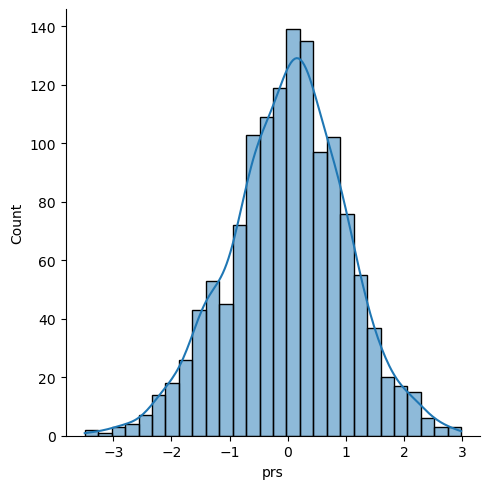

In [73]:
sns.displot(data=df_prs, x="prs", kde=True)

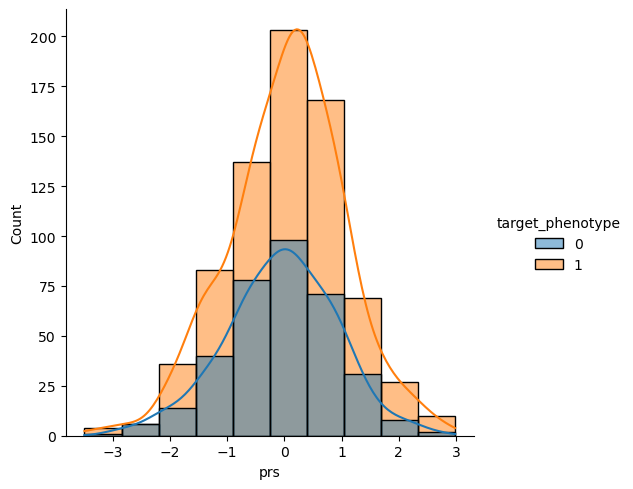

In [84]:
sns.displot(data=df_prs_phenfo, x="prs", kde=True, hue = "target_phenotype", bins = 10)


#### Calcula odds_ratio do PRS

In [58]:
from scipy.stats.contingency import odds_ratio #oddsratio
perc = []
for i in [i for i in range (1,10)]:
    a = f'{i}0%'
    perc.append(a)
print(perc)
res = []
listaDecils = [i/10 for i in range(1,10)]
print(listaDecils)
for i in range(0,9):
    var_corte = df_prs_phenfo.prs.describe(percentiles=[listaDecils[i]])[perc[i]]
    df_prs_phenfo["flag_contingencia"] = np.where(df_prs_phenfo.prs > var_corte, 1, 0)
    df_prs_phenfo.flag_contingencia.value_counts()
    a = df_prs_phenfo[(df_prs_phenfo.target_phenotype == 0) & (df_prs_phenfo.flag_contingencia ==0)].shape[0]
    b = df_prs_phenfo[(df_prs_phenfo.target_phenotype == 1) & (df_prs_phenfo.flag_contingencia ==0)].shape[0]
    c = df_prs_phenfo[(df_prs_phenfo.target_phenotype == 0) & (df_prs_phenfo.flag_contingencia ==1)].shape[0]
    d = df_prs_phenfo[(df_prs_phenfo.target_phenotype == 1) & (df_prs_phenfo.flag_contingencia ==1)].shape[0]
    tabelaCont = [[a,b],[c,d]]
    tabelaCont = pd.DataFrame(tabelaCont, columns=["phen0","phen1"])
    res.append( odds_ratio(tabelaCont, kind='conditional'))

['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%']
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


<AxesSubplot: >

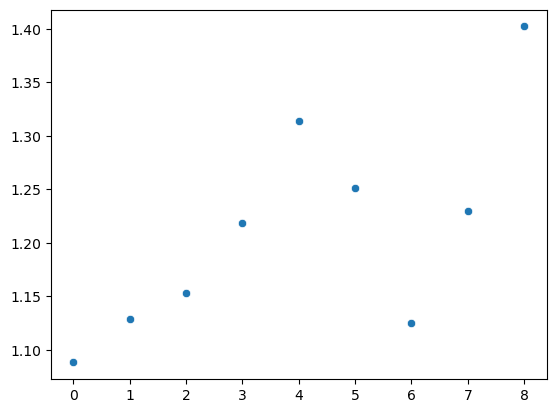

In [60]:
data = [i.statistic for i in res]
sns.scatterplot(data)